In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2, country_name_to_country_alpha3
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
plt.style.use('ggplot')

# Checking data

In [2]:
df = pd.read_csv('data/policy_list.csv')
df.START_DATE = pd.to_datetime(df.START_DATE, format = "%m_%d_%y", errors = 'coerce')
df.END_DATE = pd.to_datetime(df.END_DATE, format = "%m_%d_%y", errors = 'coerce')
#fixing wrong dates
df.loc[878, ['END_DATE']] = pd.to_datetime('2021-01-10')
df.loc[69, ['END_DATE']] = pd.to_datetime('2020-04-28')
df.loc[421, ['START_DATE']] = pd.to_datetime('2020-08-17')
df.loc[595, ['END_DATE']] = pd.to_datetime('2021-01-04')
df.loc[918, ['END_DATE']] = pd.to_datetime('2021-02-01')
df.loc[1196, ['END_DATE']] = pd.to_datetime('2021-09-21')

df = df.sort_values('START_DATE')
"""
#When variables [AIR, LAND, SEA] are equals to 0, the variables {}_TYPE and {}_TARGET are NAN
#But it isn't missing values, they should be replaced with "None"
for col in ['AIR', 'LAND', 'SEA']:
    pass
    #df.loc[df[col] == 0, col+'_TYPE'] = "None"
    #df.loc[df[col] == 0, 'TARGETS_'+col] = "None"
    
#The same problem occurs with [CITIZEN, HISTORY, REFUGEE] and {}_LIST
for col in ['CITIZEN', 'HISTORY_BAN', 'REFUGEE', 'VISA_BAN', 'COUNTRY_EXCEP', 'CITIZEN_EXCEP']:
    pass
    #df.loc[df[col] == 0, col+'_LIST'] = "None"
    
#df.loc[df['VISA_BAN'] == 0, 'VISA_BAN_TYPE'] = "None"
"""
df['DURATION'] = df.END_DATE - df.START_DATE
#remove data with no duration
df = df[df.DURATION > pd.Timedelta(seconds = 0)]

#fixing policys with country equal to 'European Union'
european_union_countries = ['Austria',  'Belgium', 'Bulgaria', 'Croatia', 'Cyprus',
                            'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
                            'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia',
                            'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland',
                            'Portugal','Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'United Kingdom']
df_wrong_country = df[df.COUNTRY_NAME == 'European Union']
new_rows = dict([(a, []) for a in df.columns])

for row in df_wrong_country.iterrows():
    for i, country in enumerate(european_union_countries):
        for col in df.columns:
            if col == 'COUNTRY_NAME':
                new_rows[col].append(country)
            elif col == 'ISO2':
                new_rows[col].append(country_name_to_country_alpha2(country))
            elif col == 'ISO3':
                new_rows[col].append(country_name_to_country_alpha3(country))
            else:
                new_rows[col].append(row[1][col])
df = df[df.COUNTRY_NAME != 'European Union']
df = pd.concat([df, pd.DataFrame(new_rows)])

#creating continent name column
unique_countries = df.COUNTRY_NAME.unique()
continents = {}
helper = {'Holy See (Vatican City State)': 'EU',
         'Timor-Leste': 'AS',
         'Republic of Kosovo': 'EU',
         'Sint Maarten (Dutch part)': 'NA',
         'European Union': 'EU'}
for i in range(len(unique_countries)):
    try:
        continents[unique_countries[i]] = country_alpha2_to_continent_code(country_name_to_country_alpha2(unique_countries[i]))
    except:
        continents[unique_countries[i]] = helper[unique_countries[i]]
df['CONTINENT'] = df.COUNTRY_NAME.apply(lambda x : continents[x])


print(f"Size of dataframe: {df.shape}")
print("Columns: ", list(df.columns))

Size of dataframe: (1274, 46)
Columns:  ['ID', 'COUNTRY_NAME', 'ISO3', 'ISO2', 'POLICY_TYPE', 'POLICY_SUBTYPE', 'START_DATE', 'END_DATE', 'AIR', 'AIR_TYPE', 'TARGETS_AIR', 'LAND', 'LAND_TYPE', 'TARGETS_LAND', 'SEA', 'SEA_TYPE', 'TARGETS_SEA', 'CITIZEN', 'CITIZEN_LIST', 'HISTORY_BAN', 'HISTORY_BAN_LIST', 'REFUGEE', 'REFUGEE_LIST', 'VISA_BAN', 'VISA_BAN_TYPE', 'VISA_BAN_LIST', 'CITIZEN_EXCEP', 'CITIZEN_EXCEP_LIST', 'COUNTRY_EXCEP', 'COUNTRY_EXCEP_LIST', 'WORK_EXCEP', 'SOURCE_QUALITY', 'SOURCE_TYPE', 'INTERNAL_GOVT_SOURCE', 'AIRLINE_SOURCE', 'INSURANCE_SOURCE', 'GOVT_SOCIAL_MED_SOURCE', 'EXT_GOVT_SOURCE', 'INTERNAL_MEDIA_SOURCE', 'EXT_MEDIA_SOURCE', 'OTHER_SOURCE', 'END_SOURCE', 'COMMENTS', 'OLD_ID', 'DURATION', 'CONTINENT']


In [3]:
print(f"Unique countries: {len(df.COUNTRY_NAME.unique())}")
print(f"Initial start date: {df.START_DATE.min()}")
print(f"Last end date: {df.END_DATE.max()}")
print(f"Policy with smallest duration: {df.DURATION.min()}")
print(f"Policy duration mean: {df.DURATION.mean()}")
print("\nType of policys:")
print(df.POLICY_TYPE.value_counts())
print("\nClosures:")
print(f"Total of air closures: {df[df.AIR == 1].shape[0]}/{df.shape[0]}")
print(f"Total of land closures: {df[df.LAND == 1].shape[0]}/{df.shape[0]}")
print(f"Total of sea closures: {df[df.SEA == 1].shape[0]}/{df.shape[0]}")
print("\nPartial closures params:")
for col in ['CITIZEN', 'HISTORY_BAN', 'REFUGEE', 'VISA_BAN']:
    print(f"{col.lower()}: {df[df[col] == 1].shape[0]}/{df.shape[0]}")
print("\nComplete closure exceptions:")    
for col in ['CITIZEN_EXCEP', 'COUNTRY_EXCEP', 'WORK_EXCEP']:
    print(f"{col.lower()}: {df[df[col] == 1].shape[0]}/{df.shape[0]}")

Unique countries: 221
Initial start date: 2020-01-24 00:00:00
Last end date: 2021-10-01 00:00:00
Policy with smallest duration: 1 days 00:00:00
Policy duration mean: 59 days 06:14:07.723704867

Type of policys:
PARTIAL     824
COMPLETE    450
Name: POLICY_TYPE, dtype: int64

Closures:
Total of air closures: 505/1274
Total of land closures: 214/1274
Total of sea closures: 178/1274

Partial closures params:
citizen: 71/1274
history_ban: 140/1274
refugee: 1/1274
visa_ban: 41/1274

Complete closure exceptions:
citizen_excep: 408/1274
country_excep: 186/1274
work_excep: 208/1274


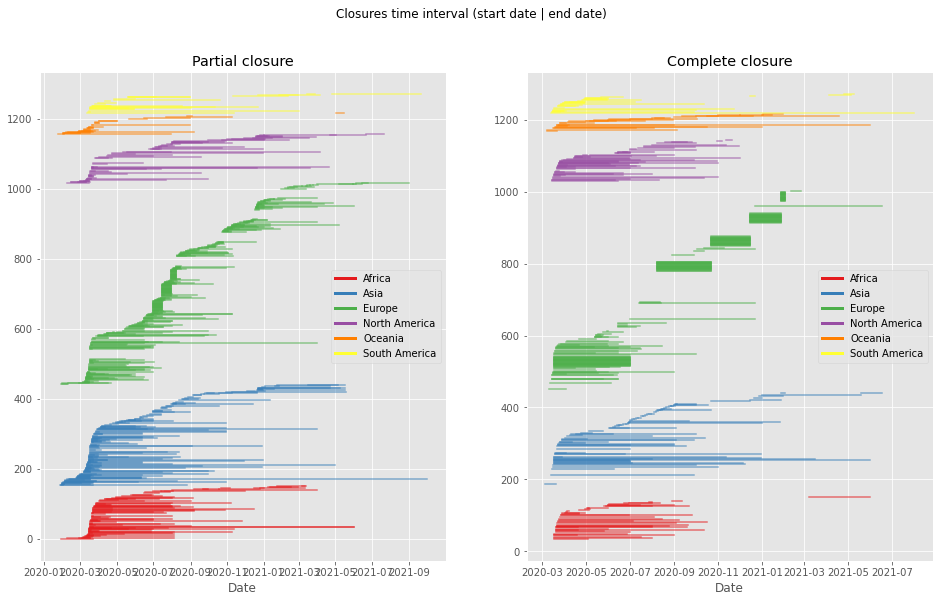

In [4]:
df = df.sort_values(['CONTINENT','START_DATE'])
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 9))
continent_config = {'AF':{'color': '#e41a1c' , 'label': 'Africa'},
                   'AS': {'color': '#377eb8', 'label' : 'Asia'},
                   'EU': {'color': '#4daf4a', 'label' : 'Europe'},
                   'NA': {'color': '#984ea3', 'label': 'North America'},
                   'OC': {'color': '#ff7f00', 'label':'Oceania'},
                   'SA': {'color': '#ffff33', 'label': 'South America'}}

for i in range(df.shape[0]):
    if not (pd.isnull(df.END_DATE.iloc[i]) or pd.isnull(df.START_DATE.iloc[i])):
        cur_continent = continents[df.COUNTRY_NAME.iloc[i]]
        cur_color = continent_config[cur_continent]['color']
        if df.POLICY_TYPE.iloc[i] == 'PARTIAL':
            ax[0].plot([df.START_DATE.iloc[i], df.END_DATE.iloc[i]], [i, i], color = cur_color, alpha = 0.6)
        elif df.POLICY_TYPE.iloc[i] == 'COMPLETE':
            ax[1].plot([df.START_DATE.iloc[i], df.END_DATE.iloc[i]], [i, i], color = cur_color, alpha = 0.6)

legend_elements = []
for key, value in continent_config.items():
    legend_elements.append(Line2D([0], [0], color = value['color'], lw = 3, label = value['label']))
plt.suptitle("Closures time interval (start date | end date)")
for i in range(2):
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel("")
    ax[i].legend(handles=legend_elements)

ax[0].set_title("Partial closure")
ax[1].set_title("Complete closure")

plt.show()

# First version of graph

In [5]:
# checking if there is more than one restriction for each row
sum_of_rest = np.sum(df[['AIR', 'LAND', 'SEA', 'CITIZEN', 'HISTORY_BAN', 'REFUGEE', 
                         'VISA_BAN', 'CITIZEN_EXCEP', 'COUNTRY_EXCEP','WORK_EXCEP']].values,
                     axis = 1)
np.unique(sum_of_rest, return_counts = True)

(array([0, 1, 2, 3], dtype=int64), array([ 31, 787, 203, 253], dtype=int64))

In [24]:
cols_boolean = ['AIR', 'LAND', 'SEA', 'CITIZEN', 'HISTORY_BAN', 'REFUGEE', 
                'VISA_BAN', 'COUNTRY_EXCEP']
cols_type = [col for col in cols_boolean if col+'_TYPE' in df.columns]

cols_names = {}
for col in cols_boolean:
    if 'TARGETS_'+col in df.columns:
        cols_names[col] = 'TARGETS_'+col
    else:
        cols_names[col] = col+'_LIST'

def add_dict(row,dic):
    for i, key in enumerate(dic):
        dic[key].append(row[i])
        
def parse_country_list(string):
    string = str(string)
    possible_seps = ['or','and']
    for sep in possible_seps:
        string.replace(sep, ',')
    list_string = string.split(sep=',')
    for i in range(len(list_string)):
        list_string[i] = list_string[i].split(sep='(')[0].strip()
    list_string = [string for string in list_string if string in countries]
    return list_string

# only considering these countries
countries = df['COUNTRY_NAME'].unique()

edges_remove = {'Source':[],'Target':[],'TYPE':[],'time_start':[],'time_end':[],'DF_ROW_ID':[]}
count = -1
for index, row in df.iterrows():
    count += 1
    country1 = row['COUNTRY_NAME']
    for col in cols_boolean:
        if row[col] == 1:
            if (col not in cols_type) or (col in cols_type and row[col+'_TYPE'] == 'Specific'):
                countries2 = parse_country_list(row[cols_names[col]])
                for country2 in countries2:
                    add_dict([country1,country2,col,row['START_DATE'],row['END_DATE'],count], edges_remove)
            elif row[col+'_TYPE'] == 'All':
                if country1 in countries:
                    add_dict([country1,'EVERYONE',col,row['START_DATE'],row['END_DATE'],count], edges_remove)

edges_remove = pd.DataFrame(edges_remove)

# remove possible errors of same source/target
edges_remove.drop(np.arange(edges_remove.shape[0])[edges_remove['Source'] == edges_remove['Target']], axis=0, inplace=True)

edges_remove.head()

,Source,Target,TYPE,time_start,time_end,DF_ROW_ID
0,Seychelles,China,HISTORY_BAN,2020-02-07,2020-08-05,1
1,Cabo Verde,Italy,AIR,2020-02-27,2020-03-18,2
2,Angola,China,HISTORY_BAN,2020-03-03,2020-03-18,3
3,Angola,Italy,HISTORY_BAN,2020-03-03,2020-03-18,3
4,Sao Tome and Principe,China,CITIZEN,2020-03-05,2020-03-20,4


In [25]:
dates = np.concatenate([edges_remove['time_start'].dropna(),
                        edges_remove['time_end'].dropna()])
dates = np.sort(np.unique(dates))
min_date = np.min(dates)
max_date = np.max(dates)

In [26]:
# drop edges with no start_date
edges_remove = edges_remove.dropna(subset=['time_start'])

# change edges with no end_date to max date from dataset
edges_remove['time_end'] = edges_remove['time_end'].fillna(max_date)

edges_remove.head()

,Source,Target,TYPE,time_start,time_end,DF_ROW_ID
0,Seychelles,China,HISTORY_BAN,2020-02-07,2020-08-05,1
1,Cabo Verde,Italy,AIR,2020-02-27,2020-03-18,2
2,Angola,China,HISTORY_BAN,2020-03-03,2020-03-18,3
3,Angola,Italy,HISTORY_BAN,2020-03-03,2020-03-18,3
4,Sao Tome and Principe,China,CITIZEN,2020-03-05,2020-03-20,4


In [27]:
#cols_boolean = ['AIR', 'LAND', 'SEA', 'CITIZEN', 'HISTORY_BAN', 'REFUGEE', 
#                'VISA_BAN', 'COUNTRY_EXCEP']
weights = np.array([1, 0, 0, 0, 0, 0, 0, 0]) # prioritizing only AIR for a test
weights = weights/weights.sum()
type_weight = {cols_boolean[i]:weights[i] for i in range(len(cols_boolean))}
edges_remove['Weight'] = [type_weight[type_i] for type_i in edges_remove['TYPE']]
edges_remove.head()

,Source,Target,TYPE,time_start,time_end,DF_ROW_ID,Weight
0,Seychelles,China,HISTORY_BAN,2020-02-07,2020-08-05,1,0.0
1,Cabo Verde,Italy,AIR,2020-02-27,2020-03-18,2,1.0
2,Angola,China,HISTORY_BAN,2020-03-03,2020-03-18,3,0.0
3,Angola,Italy,HISTORY_BAN,2020-03-03,2020-03-18,3,0.0
4,Sao Tome and Principe,China,CITIZEN,2020-03-05,2020-03-20,4,0.0


In [37]:
# obtain and remove EVERYONE rows
rows_ind_everyone = (edges_remove['Target'] == 'EVERYONE').values
rows_everyone = edges_remove.loc[rows_ind_everyone]
edges_remove.drop(np.arange(edges_remove.shape[0])[rows_ind_everyone], axis=0, inplace=True)

In [38]:
#for index, row in rows_everyone.iterrows():
def return_countries_except(country):
    return countries[(countries != country).ravel()]
rows_everyone['Target'] = rows_everyone['Source'].apply(return_countries_except)
rows_everyone = rows_everyone.explode('Target')
edges_remove = edges_remove.append(rows_everyone, ignore_index = True)

<ipython-input-38-225225ba73f7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows_everyone['Target'] = rows_everyone['Source'].apply(return_countries_except)


In [41]:
def merge_list(row):
    row_list = [row['Source'],row['Target']]
    row_list.sort()
    return (row_list[0],row_list[1])

edges_remove['Country_Duo'] = edges_remove.apply (lambda row: merge_list(row), axis=1)

In [59]:
# given a group of edges of two countries, merge weights and separate dates
def aggregate(df):
    df_dates = np.concatenate([df['time_start'].dropna(),
                               df['time_end'].dropna()])
    df_dates = np.sort(np.unique(df_dates))
    c1, c2 = df['Country_Duo'].values[0]
    new_df = {'Source':[],'Target':[],'time_start':[],'time_end':[],'Weight':[]}
    for i in range(df_dates.shape[0]-1):
        cur_time = df_dates[i]
        weight = (df['Weight'][(df['time_start']<=cur_time) & (df['time_end']>cur_time)]).sum()
        add_dict([c1, c2, cur_time, df_dates[i+1], weight], new_df)
    return pd.DataFrame(new_df)

In [60]:
grouped = edges_remove.groupby(['Country_Duo'])
final_edge_list = []
for i in grouped:
    final_edge_list.append(aggregate(i[1]))
final_edge_list = pd.concat(final_edge_list, ignore_index=True)
final_edge_list.head(10)

,Source,Target,time_start,time_end,Weight
0,Afghanistan,Albania,2020-03-15,2020-06-01,0.0
1,Afghanistan,Algeria,2020-03-17,2020-06-01,2.0
2,Afghanistan,Algeria,2020-06-01,2021-06-01,1.0
3,Afghanistan,American Samoa,2020-03-25,2020-04-01,0.0
4,Afghanistan,American Samoa,2020-04-01,2020-05-01,0.0
5,Afghanistan,Angola,2020-09-22,2020-10-19,1.0
6,Afghanistan,Angola,2020-10-19,2020-12-26,1.0
7,Afghanistan,Antigua and Barbuda,2020-04-23,2020-06-01,2.0
8,Afghanistan,Armenia,2020-08-12,2021-01-12,0.0
9,Afghanistan,Aruba,2020-07-01,2020-07-10,1.0


In [61]:
# save
final_edge_list.to_csv('data/edges.csv',index=False)

In [62]:
# load
final_edge_list = pd.read_csv('data/edges.csv')
final_edge_list.head()

,Source,Target,time_start,time_end,Weight
0,Afghanistan,Albania,2020-03-15,2020-06-01,0.0
1,Afghanistan,Algeria,2020-03-17,2020-06-01,2.0
2,Afghanistan,Algeria,2020-06-01,2021-06-01,1.0
3,Afghanistan,American Samoa,2020-03-25,2020-04-01,0.0
4,Afghanistan,American Samoa,2020-04-01,2020-05-01,0.0


In [63]:
# still working on gephi output for graph creation
final_edge_list['Timestamp'] = final_edge_list[['time_start','time_end']].values.tolist()
final_edge_list.drop(['time_start','time_end'], axis=1, inplace=True)
final_edge_list.head()

,Source,Target,Weight,Timestamp
0,Afghanistan,Albania,0.0,"[2020-03-15, 2020-06-01]"
1,Afghanistan,Algeria,2.0,"[2020-03-17, 2020-06-01]"
2,Afghanistan,Algeria,1.0,"[2020-06-01, 2021-06-01]"
3,Afghanistan,American Samoa,0.0,"[2020-03-25, 2020-04-01]"
4,Afghanistan,American Samoa,0.0,"[2020-04-01, 2020-05-01]"


In [64]:
final_edge_list.to_csv('data/edges_gephi.csv',index=False)